In [1]:
import os

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=5"
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import numpyro
import numpyro.distributions as dist
import arviz as az

print(jax.devices())
jax.config.update("jax_enable_x64", True)

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4)]


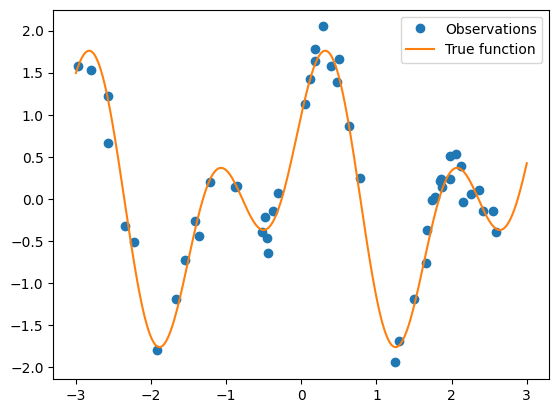

In [60]:
# dummy data - y = sin(4x)+cos(2x)
key = jax.random.PRNGKey(21)

N = 50
noise = 0.2

x_train = jax.random.uniform(key, minval=-3.0, maxval=3.0, shape=(N, 1)).sort(axis=0)


def f(x):
    return jnp.sin(4 * x) + jnp.cos(2 * x)


signal = f(x_train)
y = signal + jax.random.normal(key, shape=signal.shape) * noise

plt.plot(x_train, y, "o", label="Observations")
plt.plot(
    jnp.linspace(-3.0, 3.0, 500), f(jnp.linspace(-3.0, 3.0, 500)), label="True function"
)
plt.legend(loc="best")

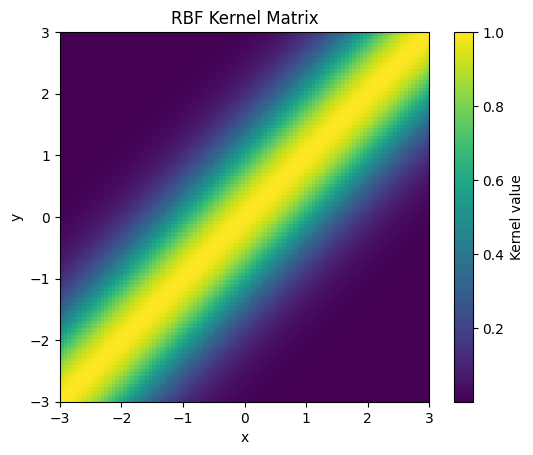

In [61]:
def rbf_kernel(x, y, params):
    ell, sigma = params["lengthscale"], params["variance"]
    return sigma * jnp.exp(-0.5 * jnp.sum(jnp.square((x - y) / ell)))


def evaluate_kernel(x, y, kernel_fn, params):
    K = jax.vmap(lambda x1: jax.vmap(lambda y1: kernel_fn(x1, y1, params))(y))(x)
    return K


# Example
params = {"lengthscale": 1.0, "variance": 1.0}
x_grid = jnp.linspace(-3.0, 3.0, 100).reshape(-1, 1)
K = evaluate_kernel(x_grid, x_grid, rbf_kernel, params)

# Plot the kernel matrix
plt.imshow(K, extent=(-3, 3, -3, 3), origin="lower", cmap="viridis")
plt.colorbar(label="Kernel value")
plt.title("RBF Kernel Matrix")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [62]:
def predict(x_train, y, params):
    n = x_train.shape[0]
    Kxx = evaluate_kernel(x_train, x_train, rbf_kernel, params["kernel"])
    Kxx += jnp.eye(n) * params["likelihood"]["obs_noise"]
    # mismatch between prior (zeros) and true y - used for updating
    prior_mean = jnp.zeros_like(x_train)
    prior_distance = y - prior_mean

    L = jax.scipy.linalg.cho_factor(Kxx, lower=True)
    weights = jax.scipy.linalg.cho_solve(L, prior_distance)

    def mean_and_variance(x_test):
        # sigma_yx
        Kfx = evaluate_kernel(x_train, x_test, rbf_kernel, params["kernel"])
        mu = jnp.dot(Kfx.T, weights)
        Kxx = evaluate_kernel(x_test, x_test, rbf_kernel, params["kernel"])
        latents = jax.scipy.linalg.cho_solve(L, Kfx)
        return mu, Kxx - jnp.dot(Kfx.T, latents)

    return mean_and_variance


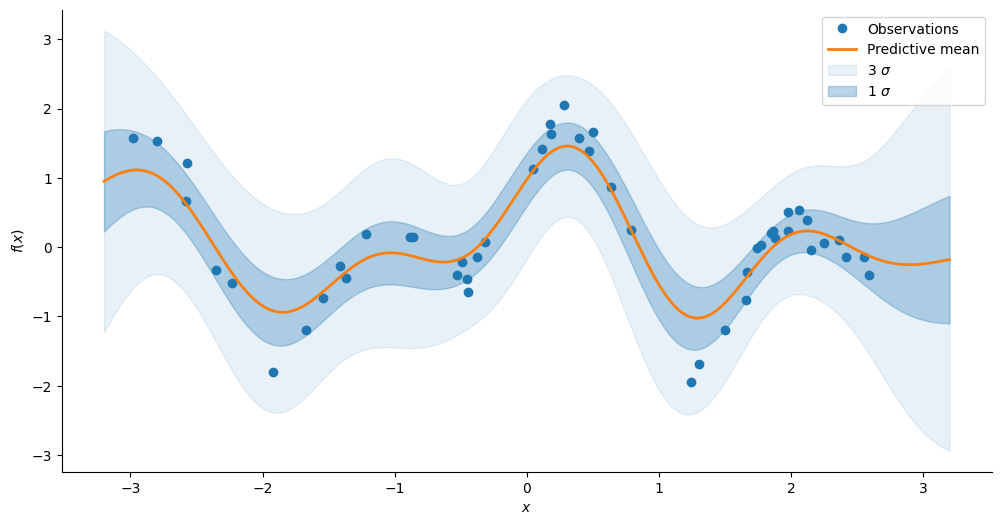

In [63]:
params = {
    "kernel": {"lengthscale": jnp.array(0.5), "variance": jnp.array(1.0)},
    "likelihood": {"obs_noise": jnp.array(1.0)},
}
x_test = jnp.linspace(-3.2, 3.2, num=300)  # .reshape(-1, 1)
mu, sigma2 = predict(x_train, y, params)(x_test)


def plot(x_train, y_train, x_test, mu, sigma2, ax=None, legend=False):
    if not ax:
        fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(x_train, y_train, "o", label="Observations")
    ax.plot(x_test, mu, label="Predictive mean", linewidth=2)
    ax.fill_between(
        x_test.squeeze(),
        mu.squeeze() - 3 * jnp.sqrt(jnp.diag(sigma2).squeeze()),
        mu.squeeze() + 3 * jnp.sqrt(jnp.diag(sigma2).squeeze()),
        alpha=0.1,
        color="tab:blue",
        label=r"3 $\sigma$",
    )
    ax.fill_between(
        x_test.squeeze(),
        mu.squeeze() - jnp.sqrt(jnp.diag(sigma2).squeeze()),
        mu.squeeze() + jnp.sqrt(jnp.diag(sigma2).squeeze()),
        alpha=0.3,
        color="tab:blue",
        label=r"1 $\sigma$",
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set(xlabel=r"$x$", ylabel=r"$f(x)$")
    return ax


ax = plot(x_train, y, x_test, mu, sigma2)
ax.legend(loc="best")

In [64]:
mu.shape

(300, 1)

# With tinygp


In [27]:
import tinygp

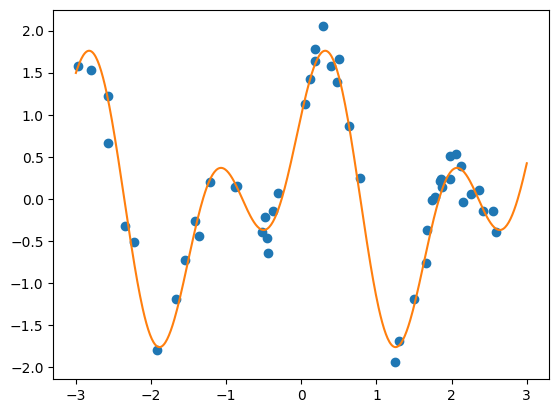

In [33]:
x_train = jax.random.uniform(key, minval=-3.0, maxval=3.0, shape=(N,)).sort(axis=0)


def f(x):
    return jnp.sin(4 * x) + jnp.cos(2 * x)


signal = f(x_train)
y = signal + jax.random.normal(key, shape=signal.shape) * noise

plt.plot(x_train, y, "o", label="Observations")
plt.plot(
    jnp.linspace(-3.0, 3.0, 500), f(jnp.linspace(-3.0, 3.0, 500)), label="True function"
)

In [34]:
kernel = tinygp.kernels.ExpSquared(0.5)
gp = tinygp.GaussianProcess(kernel, X=x_train, diag=1)
x_test = jnp.linspace(-3.2, 3.2, num=300)
_, cond_gp = gp.condition(y, x_test)

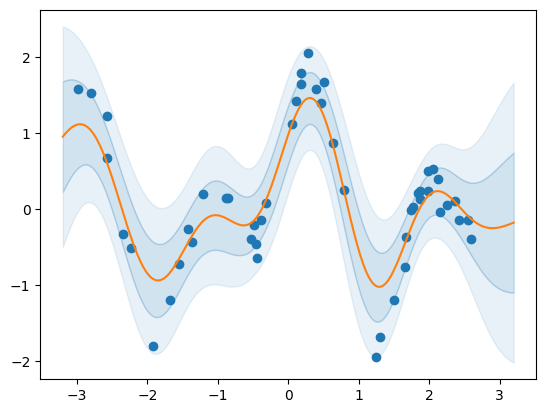

In [41]:
mu = cond_gp.mean
std = jnp.sqrt(cond_gp.variance)

plt.plot(x_train, y, "o", label="Observations")
plt.plot(x_test, mu, "C1", label="mean")
plt.fill_between(
    x_test,
    mu - std,
    mu + std,
    color="C0",
    alpha=0.2,
    label="1-sigma region",
)
plt.fill_between(
    x_test,
    mu - 2 * std,
    mu - std,
    color="C0",
    alpha=0.1,
    label="2-sigma region (lower)",
)
plt.fill_between(
    x_test,
    mu + std,
    mu + 2 * std,
    color="C0",
    alpha=0.1,
    label="2-sigma region (upper)",
)
# plt.legend()

# nyc


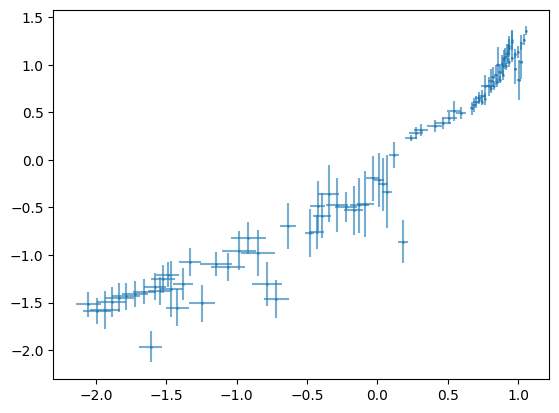

In [11]:
df = pd.read_csv("./NYC.csv")


def standardize_with_uncertainties(x: pd.Series, x_error: pd.Series):
    """Standardize both values and their uncertainties"""
    x_std = x.std()
    x_mean = x.mean()

    # For the main values: (x - mean) / std
    x_standardized = ((x - x_mean) / x_std).to_numpy()

    # For uncertainties: only divide by std (don't subtract mean)
    x_error_standardized = (x_error / x_std).to_numpy()

    return x_standardized, x_error_standardized


x_train, x_err = standardize_with_uncertainties(df["Age"] / 1000, df["AgeError"] / 1000)
y, y_err = standardize_with_uncertainties(df["RSL"], df["RSLError"])

plt.errorbar(x_train, y, xerr=x_err, yerr=y_err, fmt="o", markersize=1, alpha=0.6);

In [57]:
kernel = tinygp.kernels.ExpSquared(0.1)
gp = tinygp.GaussianProcess(kernel, X=x_train, diag=y_err)
x_test = jnp.linspace(x_train.min(), x_train.max(), num=300)
_, cond_gp = gp.condition(y, x_test)

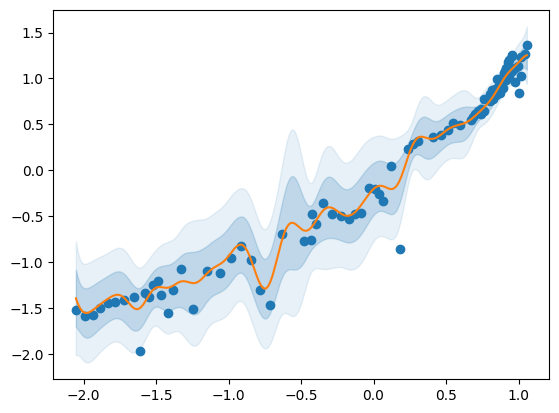

In [58]:
mu = cond_gp.mean
std = jnp.sqrt(cond_gp.variance)

plt.plot(x_train, y, "o", label="Observations")
plt.plot(x_test, mu, "C1", label="mean")
plt.fill_between(
    x_test,
    mu - std,
    mu + std,
    color="C0",
    alpha=0.2,
    label="1-sigma region",
)
plt.fill_between(
    x_test,
    mu - 2 * std,
    mu + 2 * std,
    color="C0",
    alpha=0.1,
    label="2-sigma region (lower)",
)

# My version


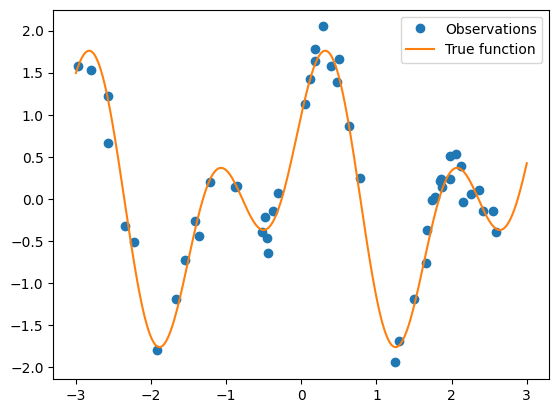

In [2]:
key = jax.random.PRNGKey(21)

N = 50
noise = 0.2

x_train = jax.random.uniform(key, minval=-3.0, maxval=3.0, shape=(N, 1)).sort(axis=0)
x_test = jnp.linspace(-3.2, 3.2, num=300).reshape(-1, 1)


def f(x):
    return jnp.sin(4 * x) + jnp.cos(2 * x)


signal = f(x_train)
y = signal + jax.random.normal(key, shape=signal.shape) * noise

plt.plot(x_train, y, "o", label="Observations")
plt.plot(
    jnp.linspace(-3.0, 3.0, 500), f(jnp.linspace(-3.0, 3.0, 500)), label="True function"
)
plt.legend(loc="best")

In [3]:
x_train.shape, y.shape, x_test.shape

((50, 1), (50, 1), (300, 1))

In [3]:
def rbf_kernel(x, y, params):
    ell, sigma = params["lengthscale"], params["variance"]
    return sigma * jnp.exp(-0.5 * jnp.sum(jnp.square((x - y) / ell)))


# @jax.jit
def evaluate_kernel(x, y, kernel_fn, params):
    K = jax.vmap(lambda x1: jax.vmap(lambda y1: kernel_fn(x1, y1, params))(y))(x)
    return K


@jax.jit
def gp_predict(x_train, y_train, x_test, params):
    train_mean = jnp.zeros_like(x_train)
    test_mean = jnp.zeros_like(x_test)

    # compute covariances.
    Σ_xx = evaluate_kernel(x_train, x_train, rbf_kernel, params["kernel"])
    Σ_xy = evaluate_kernel(x_train, x_test, rbf_kernel, params["kernel"])
    Σ_yx = Σ_xy.T
    Σ_yy = evaluate_kernel(x_test, x_test, rbf_kernel, params["kernel"])
    # if training data has noise, add to diag of cov matrix
    Σ_xx += jnp.eye(x_train.shape[0]) * params["likelihood"]["obs_noise"]

    mu = test_mean + jnp.dot(
        Σ_yx,
        # solves linear system for w: Σ_xx @ w = (X-mu_x), so w is Σ_xx^{-1}(X-mu_x)
        jax.scipy.linalg.cho_solve(
            jax.scipy.linalg.cho_factor(Σ_xx, lower=True),
            y_train - train_mean,
        ),
    )
    covariance = Σ_yy - jnp.dot(
        Σ_yx,
        # solves linear system for w: Σ_xx @ w = Σ_xy
        jax.scipy.linalg.cho_solve(
            jax.scipy.linalg.cho_factor(Σ_xx, lower=True),
            Σ_xy,
        ),
    )
    return mu, covariance


params = {
    "kernel": {"lengthscale": jnp.array(0.5), "variance": jnp.array(1.0)},
    "likelihood": {"obs_noise": jnp.array(0.2) ** 2},
}
# mu, cov = gp_predict(x_train, y, x_test, params)


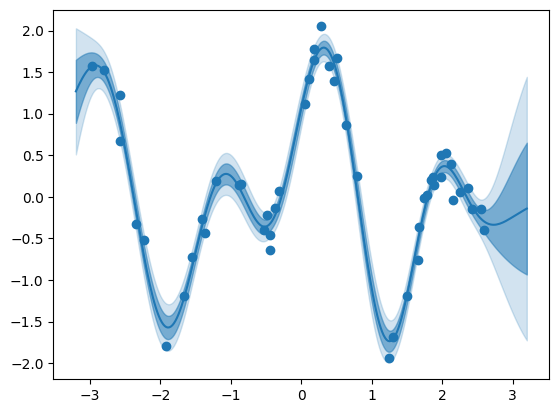

In [179]:
sigma = jnp.sqrt(jnp.diag(cov).squeeze())

plt.scatter(x_train, y)
plt.plot(x_test.squeeze(), mu.squeeze())
plt.fill_between(
    x_test.squeeze(),
    mu.squeeze() + sigma,
    mu.squeeze() - sigma,
    color="C0",
    alpha=0.5,
)
plt.fill_between(
    x_test.squeeze(),
    mu.squeeze() + 2 * sigma,
    mu.squeeze() - 2 * sigma,
    color="C0",
    alpha=0.2,
)

# NYC data with custom gp implementation


<ErrorbarContainer object of 3 artists>

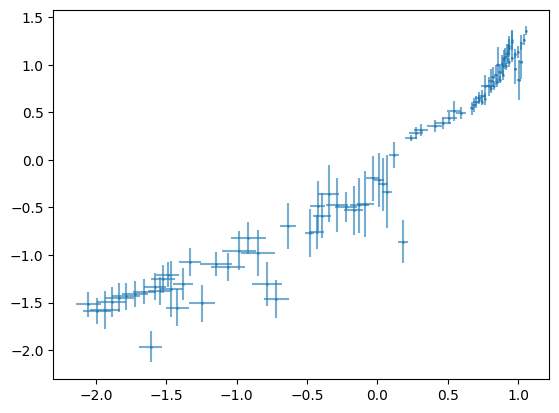

In [7]:
import pandas as pd

df = pd.read_csv("./NYC.csv")


def standardize_with_uncertainties(x: pd.Series, x_error: pd.Series):
    x_std = x.std()
    x_mean = x.mean()
    x_standardized = ((x - x_mean) / x_std).to_numpy()
    x_error_standardized = (x_error / x_std).to_numpy()
    return x_standardized, x_error_standardized


x, x_err = standardize_with_uncertainties(df["Age"] / 1000, df["AgeError"] / 1000)
y, y_err = standardize_with_uncertainties(df["RSL"], df["RSLError"])

plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt="o", markersize=1, alpha=0.6)
# plt.title("NYC data with Y axis errors");

In [ ]:
# smaller lengthscale = less-far out points effect me - less smooth- more local influence
params = {
    "kernel": {"lengthscale": jnp.array(0.1), "variance": jnp.array(1.0)},
    "likelihood": {"obs_noise": jnp.array(y_err) ** 2},
}
x_test = jnp.linspace(x.min(), x.max(), 300)
mu, cov = gp_predict(x.reshape(-1, 1), y.reshape(-1, 1), x_test.reshape(-1, 1), params)

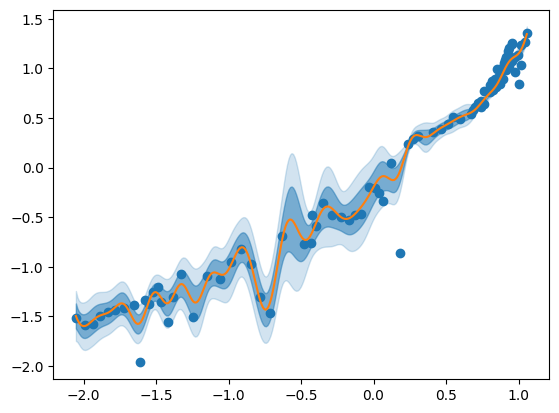

In [182]:
sigma = jnp.sqrt(jnp.diag(cov).squeeze())

plt.scatter(x, y)
plt.plot(x_test, mu.squeeze(), c="C1")
plt.fill_between(
    x_test,
    mu.squeeze() + sigma,
    mu.squeeze() - sigma,
    color="C0",
    alpha=0.5,
)
plt.fill_between(
    x_test.squeeze(),
    mu.squeeze() + 2 * sigma,
    mu.squeeze() - 2 * sigma,
    color="C0",
    alpha=0.2,
)

# Let's try learning the kernel parameters


In [4]:
import numpyro
import numpyro.distributions as dist
import arviz as az

In [ ]:
def model(x_train, y_train, y_err):
    lengthscale = numpyro.sample("l", dist.Uniform(0.01, 1))
    variance = numpyro.sample("variance", dist.Exponential(1))
    kernel_params = {"lengthscale": lengthscale, "variance": variance}

    Σ_xx = evaluate_kernel(x_train, x_train, rbf_kernel, kernel_params)
    # sq since we need to add variance to the cov matrix
    Σ_xx += jnp.eye(x_train.shape[0]) * (y_err**2)
    train_mean = jnp.zeros_like(x_train)
    numpyro.sample("y_train", dist.MultivariateNormal(train_mean, Σ_xx), obs=y_train)


mcmc = numpyro.infer.MCMC(
    numpyro.infer.NUTS(model, dense_mass=True),
    num_warmup=500,
    num_samples=1000,
)
mcmc.run(jax.random.PRNGKey(1), x_train=x, y_train=y, y_err=y_err)
mcmc.print_summary()


sample: 100%|██████████| 1500/1500 [00:12<00:00, 116.68it/s, 7 steps of size 6.90e-01. acc. prob=0.94]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         l      0.63      0.10      0.63      0.48      0.78    668.54      1.00
  variance      1.49      0.82      1.31      0.40      2.58    518.42      1.00

Number of divergences: 0


now, we have a _distribution_ of gaussian processes, corresponding to different samples of kernel parameters lengthscale and variance. When looking at the trace, the dist for l looked like a truncated normal so i increased the rage it can take by changing the boundsof the uniform distribution. But we can also limit the lengthscale if the result is overly smooth


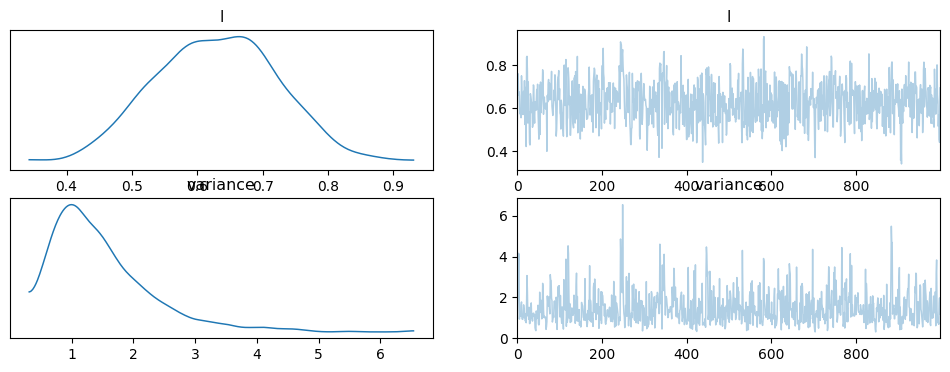

In [187]:
idata = az.from_numpyro(mcmc)
az.plot_trace(idata);

dict_keys(['l', 'variance'])
(1000, 300, 1) (1000, 300, 300)


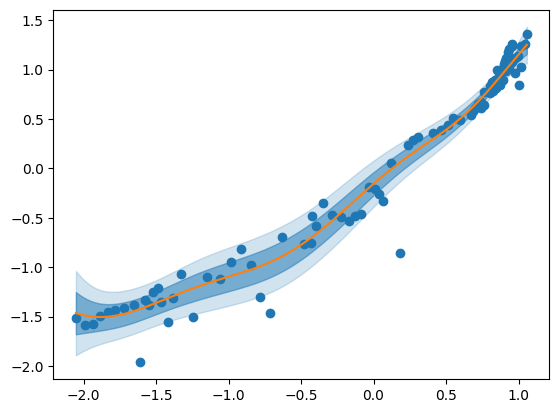

In [188]:
samples = mcmc.get_samples()
print(samples.keys())


def fit_one_gp(lengthscale, var):
    params = {
        "kernel": {"lengthscale": lengthscale, "variance": var},
        "likelihood": {"obs_noise": jnp.array(y_err)},
    }
    # fit it over x_test values this time
    mu, cov = gp_predict(
        x.reshape(-1, 1), y.reshape(-1, 1), x_test.reshape(-1, 1), params
    )
    return mu, cov


posterior_mu, posterior_cov = jax.vmap(fit_one_gp)(samples["l"], samples["variance"])
print(posterior_mu.shape, posterior_cov.shape)

# NOTE this can probably improve - double check!
# let's use the mean (gp means, gp covs)
mean_mu = posterior_mu.mean(axis=0).squeeze()
# mean_cov = posterior_cov.mean(axis=0)
# mean_mu = posterior_mu[10].squeeze()
# mean_cov = posterior_cov[10]
# sigma = jnp.sqrt(jnp.diag(mean_cov).squeeze())
mean_variance = jnp.mean(jnp.diagonal(posterior_cov, axis1=1, axis2=2), axis=0)
variance_mean = jnp.var(posterior_mu.squeeze(), axis=0)
sigma = jnp.sqrt(mean_variance + variance_mean)

plt.scatter(x, y)
plt.plot(x_test, mean_mu, c="C1")
plt.fill_between(
    x_test,
    mean_mu + sigma,
    mean_mu - sigma,
    color="C0",
    alpha=0.5,
)
plt.fill_between(
    x_test.squeeze(),
    mean_mu + 2 * sigma,
    mean_mu - 2 * sigma,
    color="C0",
    alpha=0.2,
)

## another one with lengthscale fixed

NOTE the y_err needs to be squared! It represents std dev, not variance


In [189]:
def model(x_train, y_train, y_err):
    lengthscale = 0.1
    variance = numpyro.sample("variance", dist.Exponential(1))
    kernel_params = {"lengthscale": lengthscale, "variance": variance}

    Σ_xx = evaluate_kernel(x_train, x_train, rbf_kernel, kernel_params)
    Σ_xx += jnp.eye(x_train.shape[0]) * (y_err**2)
    train_mean = jnp.zeros_like(x_train)
    numpyro.sample("y_train", dist.MultivariateNormal(train_mean, Σ_xx), obs=y_train)


mcmc = numpyro.infer.MCMC(
    numpyro.infer.NUTS(model, dense_mass=True),
    num_warmup=500,
    num_samples=1000,
)
mcmc.run(jax.random.PRNGKey(1), x_train=x, y_train=y, y_err=y_err)
mcmc.print_summary()


sample: 100%|██████████| 1500/1500 [00:05<00:00, 275.57it/s, 3 steps of size 9.46e-01. acc. prob=0.91]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  variance      0.59      0.16      0.57      0.36      0.84    360.58      1.00

Number of divergences: 0


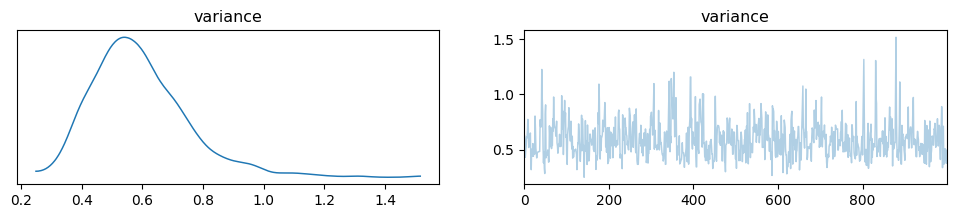

In [190]:
idata = az.from_numpyro(mcmc)
az.plot_trace(idata);

dict_keys(['variance'])
(1000, 300, 1) (1000, 300, 300)


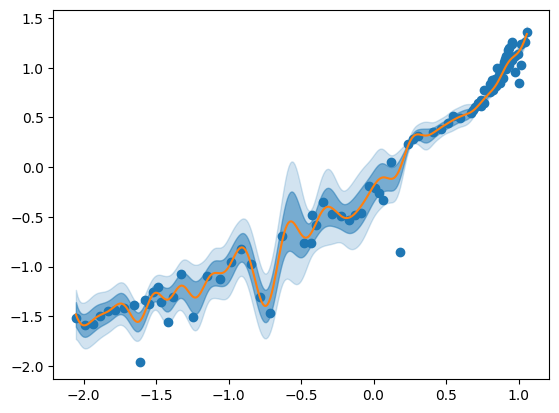

In [191]:
samples = mcmc.get_samples()
print(samples.keys())


def fit_one_gp(var):
    params = {
        "kernel": {"lengthscale": 0.1, "variance": var},
        "likelihood": {"obs_noise": jnp.array(y_err**2)},
    }
    # fit it over x_test values this time
    mu, cov = gp_predict(
        x.reshape(-1, 1), y.reshape(-1, 1), x_test.reshape(-1, 1), params
    )
    return mu, cov


posterior_mu, posterior_cov = jax.vmap(fit_one_gp)(samples["variance"])
print(posterior_mu.shape, posterior_cov.shape)

# NOTE this can probably improve - double check!
# let's use the mean (gp means, gp covs)
mean_mu = posterior_mu.mean(axis=0).squeeze()
# mean_cov = posterior_cov.mean(axis=0)
# mean_mu = posterior_mu[10].squeeze()
# mean_cov = posterior_cov[10]
# sigma = jnp.sqrt(jnp.diag(mean_cov).squeeze())
mean_variance = jnp.mean(jnp.diagonal(posterior_cov, axis1=1, axis2=2), axis=0)
variance_mean = jnp.var(posterior_mu.squeeze(), axis=0)
sigma = jnp.sqrt(mean_variance + variance_mean)

plt.scatter(x, y)
plt.plot(x_test, mean_mu, c="C1")
plt.fill_between(
    x_test,
    mean_mu + sigma,
    mean_mu - sigma,
    color="C0",
    alpha=0.5,
)
plt.fill_between(
    x_test.squeeze(),
    mean_mu + 2 * sigma,
    mean_mu - 2 * sigma,
    color="C0",
    alpha=0.2,
)

# Lengthscale and variance fixed, but incorporate EIV


In [200]:
def model(x_train, y_train, x_err, y_err):
    n = x_train.shape[0]
    lengthscale = 0.1
    variance = 5
    # lengthscale = numpyro.sample("l", dist.Uniform(0.0, 1))
    # variance = numpyro.sample("variance", dist.Exponential(1))
    # micro-scale variance
    sigma = numpyro.sample("sigma", dist.Uniform(0.01, 1))
    kernel_params = {"lengthscale": lengthscale, "variance": variance}

    # makes sense rather than having a wildly unconstrained prior
    x_true = numpyro.sample("x_true", dist.Normal(x_train, x_err).to_event(1))
    # x_true = numpyro.sample("x_true", dist.Uniform(-3, 3).expand([n]))
    # x_true = numpyro.sample("x_true", dist.Normal(0, jnp.sqrt(1000.0)).expand([n]))
    # x_true = numpyro.sample("x_true", dist.Normal(x_train, x_err).to_event(1))
    # print(x_true.shape)
    Σ_xx = evaluate_kernel(x_true, x_true, rbf_kernel, kernel_params)
    Σ_xx += jnp.eye(n) * ((y_err**2) + (sigma**2))
    train_mean = jnp.zeros_like(x_train)
    # with numpyro.plate("x_likelihood_plate", len(x_true)):
    #     numpyro.sample(
    #         "x_likelihood", dist.Normal(loc=x_true, scale=x_err), obs=x_train
    #     )
    numpyro.sample(
        "x_likelihood", dist.Normal(loc=x_true, scale=x_err).to_event(1), obs=x_train
    )

    numpyro.sample(
        "y_likelihood", dist.MultivariateNormal(train_mean, Σ_xx), obs=y_train
    )


mcmc = numpyro.infer.MCMC(
    numpyro.infer.NUTS(model, dense_mass=True),
    num_warmup=500,
    num_samples=1000,
)
mcmc.run(jax.random.PRNGKey(1), x_train=x, y_train=y, x_err=x_err, y_err=y_err)
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [01:08<00:00, 22.03it/s, 31 steps of size 1.20e-01. acc. prob=0.88]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      0.02      0.01      0.02      0.01      0.03    911.33      1.00
 x_true[0]      0.72      0.00      0.72      0.72      0.73    938.05      1.00
 x_true[1]      0.74      0.00      0.74      0.73      0.75   2309.19      1.00
 x_true[2]      0.76      0.00      0.76      0.75      0.77   1615.56      1.00
 x_true[3]      0.80      0.00      0.80      0.80      0.81   1704.51      1.00
 x_true[4]      0.83      0.00      0.83      0.82      0.83   2164.64      1.00
 x_true[5]      0.85      0.00      0.85      0.84      0.85   2119.76      1.00
 x_true[6]      0.87      0.00      0.87      0.86      0.87   1806.43      1.00
 x_true[7]      0.89      0.00      0.89      0.88      0.90   2083.62      1.00
 x_true[8]      0.91      0.00      0.91      0.90      0.92   1716.70      1.00
 x_true[9]      0.93      0.00      0.93      0.93      0.94   1849.04      1.00
x_true[10]      0.96      0

In [196]:
# idata = az.from_numpyro(mcmc)
# az.plot_trace(idata, var_names=["l", "variance"]);

In [201]:
samples = mcmc.get_samples()

(1000, 300, 1) (1000, 300, 300)


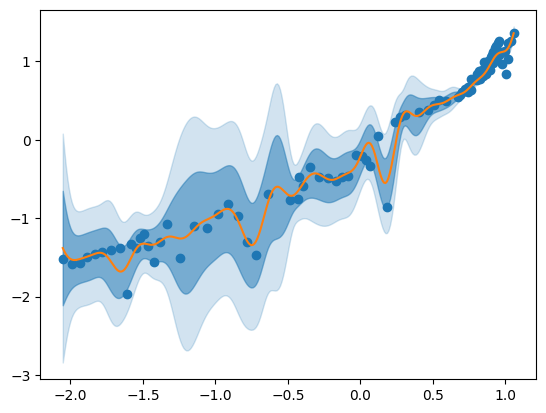

In [202]:
def fit_one_gp(x_sampled):
    params = {
        "kernel": {"lengthscale": 0.1, "variance": 5},
        "likelihood": {"obs_noise": jnp.array(y_err) ** 2},
    }
    # fit it over x_test values this time
    mu, cov = gp_predict(
        x_sampled.reshape(-1, 1), y.reshape(-1, 1), x_test.reshape(-1, 1), params
    )
    return mu, cov


# posterior_mu, posterior_cov = jax.vmap(fit_one_gp)(
#     samples["l"], samples["variance"], samples["x_true"]
# )
posterior_mu, posterior_cov = jax.vmap(fit_one_gp)(samples["x_true"])
print(posterior_mu.shape, posterior_cov.shape)

# NOTE this can probably improve - double check!
# let's use the mean (gp means, gp covs)
mean_mu = posterior_mu.mean(axis=0).squeeze()
# mean_cov = posterior_cov.mean(axis=0)
# mean_mu = posterior_mu[10].squeeze()
# mean_cov = posterior_cov[10]
# sigma = jnp.sqrt(jnp.diag(mean_cov).squeeze())
mean_variance = jnp.mean(jnp.diagonal(posterior_cov, axis1=1, axis2=2), axis=0)
variance_mean = jnp.var(posterior_mu.squeeze(), axis=0)
sigma = jnp.sqrt(mean_variance + variance_mean)

plt.scatter(x, y)
plt.plot(x_test, mean_mu, c="C1")
plt.fill_between(
    x_test,
    mean_mu + sigma,
    mean_mu - sigma,
    color="C0",
    alpha=0.5,
)
plt.fill_between(
    x_test.squeeze(),
    mean_mu + 2 * sigma,
    mean_mu - 2 * sigma,
    color="C0",
    alpha=0.2,
)

# Let's Try EIV IGP!


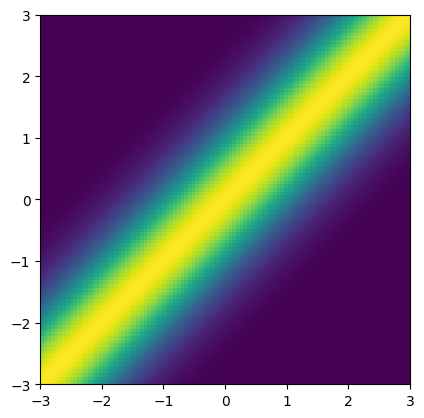

In [5]:
def powered_exponential(x, y, params):
    p, kappa, sigma = params["p"], params["kappa"], params["variance"]
    return sigma * p ** (jnp.abs(x - y) ** kappa)


params = {"p": 0.5, "kappa": 1.99, "variance": 1}
x_grid = jnp.linspace(-3.0, 3.0, 100).reshape(-1, 1)
K = evaluate_kernel(x_grid, x_grid, powered_exponential, params)

# Plot the kernel matrix
plt.imshow(K, extent=(-3, 3, -3, 3), origin="lower", cmap="viridis")

In [ ]:
import pandas as pd

df = pd.read_csv("./NYC.csv")
df.head()

,Age,RSL,AgeError,RSLError,Type
0,1857.5,-0.382722,1.25,0.020224,TG
1,1865.0,-0.390889,2.50,0.019072,TG
2,1875.0,-0.375111,2.50,0.038143,TG
3,1895.0,-0.303651,2.50,0.019982,TG
4,1905.0,-0.290822,2.50,0.029349,TG


In [9]:
x = df["Age"].to_numpy() / 1000
x_std = df["AgeError"].to_numpy() / 1000
y = df["RSL"].to_numpy()
y_std = df["RSLError"].to_numpy()
interval = 30 / 1000

x_grid = np.concatenate(
    [
        [(x - x_std).min()],
        np.arange(x.min(), x.max(), interval),
        [(x + x_std).max()],
    ]
)
x_star = x_grid - x.min()
x = x - x.min()


#  quadrature
L = 30
kappa = 1.99
Ngrid = len(x_star)
index = np.arange(1, L + 1)
cosfunc = np.cos((np.pi * (2 * index - 1)) / (2 * L))

quad1 = np.zeros((len(df), Ngrid, L))
quad2 = np.ones((len(df), Ngrid, L))
for j in range(Ngrid):
    for k in range(len(df)):
        quad1[k, j, :] = np.abs((x[k] * cosfunc / 2) + (x[k] / 2) - x_star[j]) ** kappa
        quad2[k, j, :] = (x[k] / 2) * (np.pi / L) * (np.sqrt(1 - cosfunc**2))


In [ ]:
def igp(x, y, x_std, y_std):
    # N = x.shape[0]
    p = numpyro.sample("p", dist.Uniform(0.0, 1.0))
    kernel_precision = numpyro.sample("tau_g", dist.Gamma(10.0, 100.0))
    kernel_variance = 1 / kernel_precision
    microscale_std = numpyro.sample("sigma", dist.Uniform(0.01, 1.0))
    params = {"p": p, "kappa": 1.99, "variance": kernel_variance}

    # kernel computation and EIV sampling
    x_true = numpyro.sample("x_true", dist.Normal(x, x_std).to_event(1))
    numpyro.sample(
        "x_likelihood", dist.Normal(loc=x_true, scale=x_std).to_event(1), obs=x
    )

    Σ_ww = evaluate_kernel(x_star, x_star, powered_exponential, params)
    Σ_ww += jnp.eye(len(x_star)) * 1e-6  # jitter
    # sample rates
    # Sample w_m (rates on grid) from its prior MVN(0, K_ww)
    w_m = numpyro.sample("w_m", dist.MultivariateNormal(jnp.zeros(len(x_star)), Σ_ww))

    # Integration and MVN sampling - todo!!
    K_gw = jnp.sum(p**quad1 * quad2, axis=2)
    K_hw = kernel_variance * K_gw
    # GP conditioning calculations
    L_ww = jax.scipy.linalg.cholesky(Σ_ww, lower=True)
    x_sol = jax.scipy.linalg.solve_triangular(L_ww, w_m, lower=True)
    K_ww_inv_w_m = jax.scipy.linalg.solve_triangular(L_ww, x_sol, lower=True, trans="T")

    h_integral_cond_exp = jnp.matmul(K_hw, K_ww_inv_w_m)
    numpyro.sample(
        "y_likelihood",
        dist.Normal(
            h_integral_cond_exp, jnp.sqrt(y_std**2 + microscale_std**2)
        ).to_event(1),
        obs=y,
    )


mcmc = numpyro.infer.MCMC(
    numpyro.infer.NUTS(igp, dense_mass=True),
    num_warmup=500,
    num_samples=1000,
    num_chains=4,
)
mcmc.run(jax.random.PRNGKey(1), x=x, y=y, x_std=x_std, y_std=y_std)
mcmc.print_summary()

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [25]:
len(x_star)

50

In [18]:
import pickle

samples = mcmc.get_samples()
if "kernel_variance" not in samples:
    samples["kernel_variance"] = 1.0 / samples["tau_g"]

samples.keys()
# Save the samples dictionary to a file
# with open("samples.pkl", "wb") as f:
#     pickle.dump(samples, f)

dict_keys(['p', 'sigma', 'tau_g', 'w_m', 'x_true', 'kernel_variance'])

In [ ]:
# Define the predictive model
predictive = numpyro.infer.Predictive(igp, posterior_samples=samples, num_samples=1000)

# Generate posterior predictive samples
posterior_predictive_samples = predictive(
    jax.random.PRNGKey(0), x=x, y=y, x_std=x_std, y_std=y_std
)

print(posterior_predictive_samples.keys())
# # Extract the posterior predictive mean and standard deviation
# posterior_predictive_mean = jnp.mean(
#     posterior_predictive_samples["y_likelihood"], axis=0
# )
# posterior_predictive_std = jnp.std(posterior_predictive_samples["y_likelihood"], axis=0)

# # Plot the posterior predictive distribution
# plt.figure(figsize=(10, 6))
# plt.scatter(x, y, label="Observations")
# plt.plot(
#     x_test, posterior_predictive_mean, label="Posterior Predictive Mean", color="C1"
# )
# plt.fill_between(
#     x_test.squeeze(),
#     posterior_predictive_mean - 2 * posterior_predictive_std,
#     posterior_predictive_mean + 2 * posterior_predictive_std,
#     color="C0",
#     alpha=0.2,
#     label="95% Credible Interval",
# )
# plt.legend()
# plt.xlabel("x")
# plt.ylabel("y")
# plt.title("Posterior Predictive Distribution")
# plt.show()

dict_keys(['x_likelihood', 'y_likelihood'])


In [40]:
posterior_predictive_samples["y_likelihood"].shape

(1000, 91)

In [ ]:
# @jax.jit
def gp_predict_pe(x_train, y_train, x_test, params):
    train_mean = jnp.zeros_like(x_train)
    test_mean = jnp.zeros_like(x_test)

    # compute covariances.
    Σ_xx = evaluate_kernel(x_train, x_train, powered_exponential, params["kernel"])
    Σ_xy = evaluate_kernel(x_train, x_test, powered_exponential, params["kernel"])
    Σ_yx = Σ_xy.T
    Σ_yy = evaluate_kernel(x_test, x_test, powered_exponential, params["kernel"])
    # if training data has noise, add to diag of cov matrix
    Σ_xx += jnp.eye(x_train.shape[0]) * params["likelihood"]["obs_noise"].squeeze()

    mu = test_mean + jnp.dot(
        Σ_yx,
        # solves linear system for w: Σ_xx @ w = (X-mu_x), so w is Σ_xx^{-1}(X-mu_x)
        jax.scipy.linalg.cho_solve(
            jax.scipy.linalg.cho_factor(Σ_xx, lower=True),
            y_train - train_mean,
        ),
    )
    covariance = Σ_yy - jnp.dot(
        Σ_yx,
        # solves linear system for w: Σ_xx @ w = Σ_xy
        jax.scipy.linalg.cho_solve(
            jax.scipy.linalg.cho_factor(Σ_xx, lower=True),
            Σ_xy,
        ),
    )
    return mu, covariance


# der process at test points


x_test = jnp.linspace(x_star[0], x_star[-1], 300)


def fit_one_gp(p, tau, sigma, x_true):
    params = {
        "kernel": {"p": p, "kappa": 1.99, "variance": 1 / tau},
        "likelihood": {"obs_noise": jnp.array(jnp.sqrt(y_std**2 + sigma**2))},
    }
    print("Likelihood noise shape:", params["likelihood"]["obs_noise"].shape)
    print("x_true shape:", x_true.shape)
    mu, cov = gp_predict_pe(
        x_true.reshape(-1, 1), y.reshape(-1, 1), x_test.reshape(-1, 1), params
    )
    return mu, cov


_ = fit_one_gp(
    samples["p"][0],
    samples["tau_g"][0],
    samples["sigma"][0],
    samples["x_true"][0],
)

# posterior_mu, posterior_cov = jax.vmap(fit_one_gp)(
#     samples["p"], samples["tau_g"], samples["sigma"], samples["x_true"]
# )
# new quadrature functions at these points
# solve for integrated process

Likelihood noise shape: (91,)
x_true shape: (91,)


ValueError: The arguments to solve must have shapes a=[..., m, m] and b=[..., m, k] or b=[..., m]; got a=(91, 91, 91) and b=(91, 1)

In [22]:
samples["w_m"].shape

(1000, 50)

Shape of posterior predictive means for w(t): (1000, 100)
Shape of posterior predictive variances for w(t): (1000, 100)


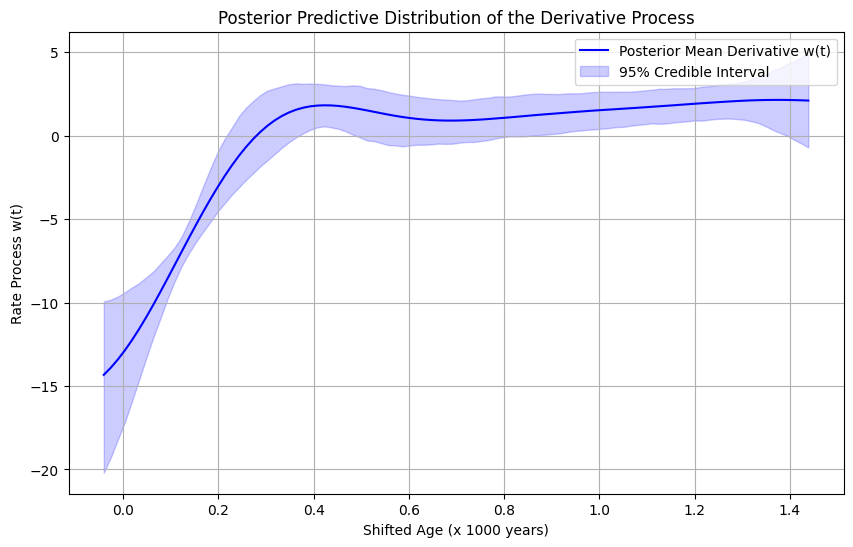

In [46]:
# Define test points (use the same shifted coordinate system)
x_test = jnp.linspace(x_star.min(), x_star.max(), 100)

# Ensure x_star and x_test are column vectors for evaluate_kernel
# x_star_col = jnp.asarray(x_star).reshape(-1, 1)
# x_test_col = jnp.asarray(x_test).reshape(-1, 1)


def predict_derivative_gp_single_sample(p_sample, variance_sample, wm_sample):
    kappa_val = 1.99
    jitter = 1e-5
    params = {"p": p_sample, "kappa": kappa_val, "variance": variance_sample}
    Ngrid = x_star.shape[0]
    # Ntest = x_test_pts.shape[0]

    # Calculate kernel matrices
    Σ_ww = evaluate_kernel(x_star, x_star, powered_exponential, params)
    Σ_ww += jnp.eye(Ngrid) * jitter

    Σ_test_test = evaluate_kernel(x_test, x_test, powered_exponential, params)
    # No jitter usually needed for Σ_test_test unless using it for further conditioning

    Σ_test_w = evaluate_kernel(x_test, x_star, powered_exponential, params)
    Σ_w_test = Σ_test_w.T

    # GP Conditioning using Cholesky decomposition for stability
    L_ww, lower = jax.scipy.linalg.cho_factor(Σ_ww, lower=True)  # Use cho_factor

    wm_col = wm_sample

    # Solve L_ww @ alpha = wm_col
    alpha = jax.scipy.linalg.solve_triangular(
        L_ww, wm_col, lower=True, trans="N"
    )  # alpha is (Ngrid, 1)
    # Solve L_ww.T @ beta = alpha  => beta = Σ_ww^-1 @ wm_col
    beta = jax.scipy.linalg.solve_triangular(
        L_ww, alpha, lower=True, trans="T"
    )  # beta is (Ngrid, 1)

    # Predictive mean: μ_pred = Σ_{test,w} @ beta
    pred_mean_col = jnp.dot(Σ_test_w, beta)  # pred_mean_col is (Ntest, 1)
    pred_mean = pred_mean_col  # .squeeze(axis=-1)  # Squeeze back to (Ntest,)

    # Predictive covariance: Σ_pred = Σ_{test,test} - Σ_{test,w} @ Σ_ww^{-1} @ Σ_{w,test}
    # Use cho_solve: Solves Σ_ww @ x = Σ_w_test for x
    # Σ_w_test has shape (Ngrid, Ntest)
    cho_solve_result = jax.scipy.linalg.cho_solve(
        (L_ww, lower), Σ_w_test
    )  # result shape (Ngrid, Ntest)
    pred_cov = Σ_test_test - jnp.dot(
        Σ_test_w, cho_solve_result
    )  # pred_cov shape (Ntest, Ntest)

    # We only need the diagonal for variance
    pred_var = jnp.diag(pred_cov)  # pred_var shape (Ntest,)

    # Ensure variance is non-negative (numerical issues might cause small negatives)
    pred_var = jnp.maximum(pred_var, 0.0)

    return pred_mean, pred_var


# Vectorize the prediction function over the samples
# Specify which arguments correspond to the samples (axis 0)
# Note: x_star_col, x_test_col, kappa are static
vectorized_predict = jax.vmap(predict_derivative_gp_single_sample)

# Run the vectorized prediction across all MCMC samples
# Ensure samples have the necessary keys and correct shapes
posterior_pred_mean_w, posterior_pred_var_w = vectorized_predict(
    samples["p"],
    samples["kernel_variance"],  # Use kernel_variance directly
    samples["w_m"],
)

# posterior_pred_mean_w shape: (num_samples, num_test_points)
# posterior_pred_var_w shape: (num_samples, num_test_points)

print("Shape of posterior predictive means for w(t):", posterior_pred_mean_w.shape)
print("Shape of posterior predictive variances for w(t):", posterior_pred_var_w.shape)

# You can now calculate summary statistics (mean, quantiles) over the samples
mean_pred_w = jnp.mean(posterior_pred_mean_w, axis=0)
std_pred_w = jnp.sqrt(
    jnp.mean(posterior_pred_var_w + posterior_pred_mean_w**2, axis=0) - mean_pred_w**2
)  # Law of total variance
# Or simpler: std_dev = sqrt(mean_of_variances + variance_of_means)
# Or just get quantiles from the samples directly for credible intervals

# Example: Calculate 95% credible interval for the derivative process
q_w = np.percentile(posterior_pred_mean_w, [2.5, 97.5], axis=0)


plt.figure(figsize=(10, 6))
plt.plot(x_test, mean_pred_w, label="Posterior Mean Derivative w(t)", color="blue")
plt.fill_between(
    x_test, q_w[0, :], q_w[1, :], color="blue", alpha=0.2, label="95% Credible Interval"
)

# Optionally plot some individual sample paths
# for i in range(min(20, posterior_pred_mean_w.shape[0])): # Plot first 20 samples
#     plt.plot(x_test, posterior_pred_mean_w[i, :], color='grey', alpha=0.1)

plt.xlabel("Shifted Age (x 1000 years)")
plt.ylabel("Rate Process w(t)")
plt.title("Posterior Predictive Distribution of the Derivative Process")
plt.legend()
plt.grid(True)
plt.show()

Shape of quad1_test: (100, 50, 30)
Shape of quad2_test: (100, 50, 30)
Shape of posterior predictive means for h(t): (1000, 100)
Shape of posterior predictive variances for h(t): (1000, 100)


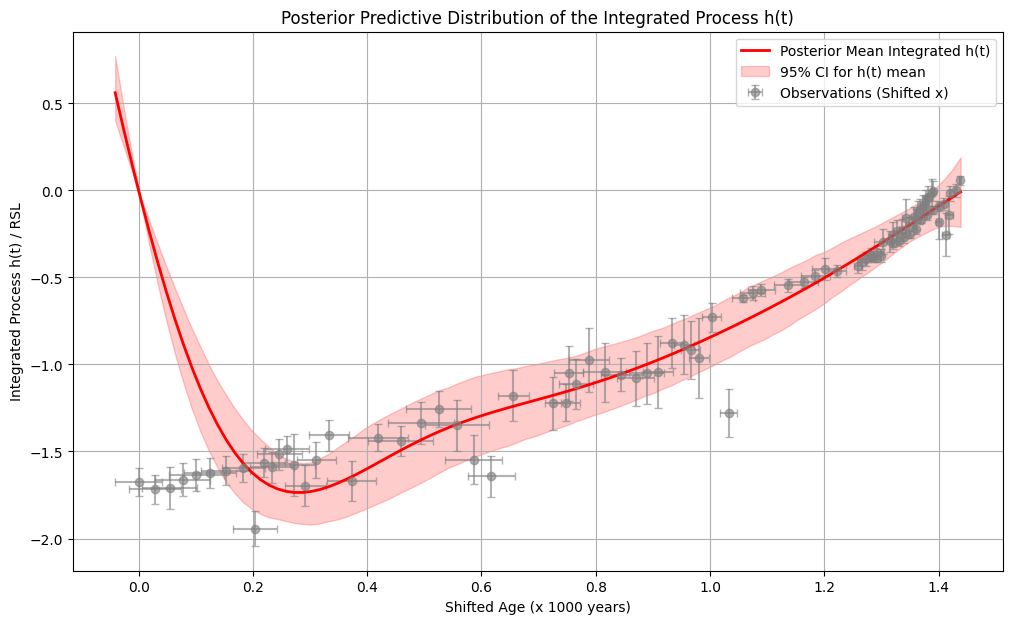

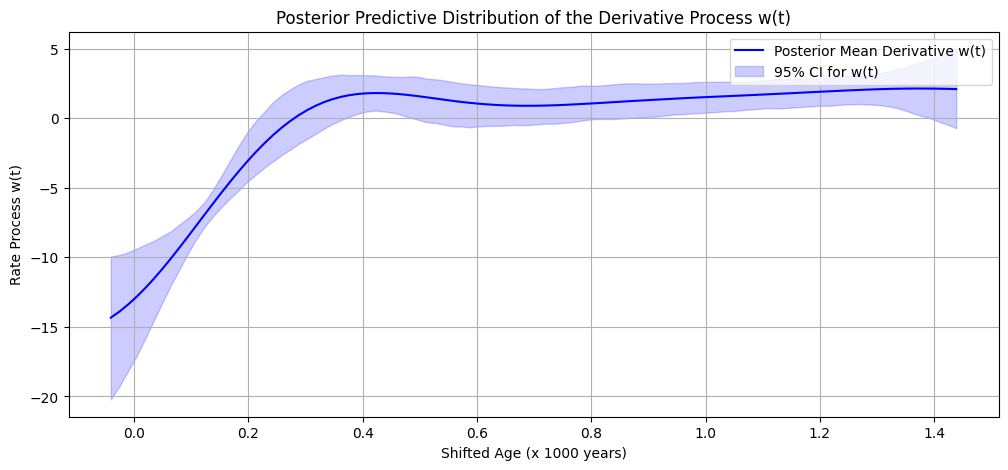

In [47]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import cho_factor, cho_solve, solve_triangular
import numpy as np
import matplotlib.pyplot as plt

# --- Assume previous setup code is run ---
# Includes: x_orig, x_std, y, y_std, x_min_global, x, x_max_global
#           x_grid, x_star, interval
#           L, kappa, Ngrid, index, cosfunc
#           powered_exponential, evaluate_kernel
#           MCMC samples dict 'samples' (or dummy samples)
#           x_test (1D array of test points in shifted coordinates)

# Ensure necessary variables are defined (using dummy values if needed)
try:
    _ = L, kappa, Ngrid, index, cosfunc, x_star, x_test, samples
except NameError:
    print("Warning: Redefining some dummy variables for demonstration.")
    L = 30
    kappa = 1.99
    x_star = np.linspace(0, 10, 50)  # Dummy shifted x_star
    Ngrid = len(x_star)
    index = np.arange(1, L + 1)
    cosfunc = np.cos((np.pi * (2 * index - 1)) / (2 * L))
    x_test = np.linspace(x_star.min(), x_star.max(), 100)  # Dummy shifted x_test
    num_samples = 50  # Must match the number of samples used for w prediction
    samples = {
        "p": np.random.uniform(0.1, 0.9, num_samples),
        "kernel_variance": 1.0 / np.random.gamma(10.0, 1 / 100.0, num_samples),
        "w_m": np.random.multivariate_normal(
            np.zeros(Ngrid), np.eye(Ngrid) * 0.1, size=num_samples
        ),
    }


# --- Quadrature for Cov(h(x_test), w(x_star)) ---
Ntest = len(x_test)
quad1_test = np.zeros((Ntest, Ngrid, L))
quad2_test = np.zeros(
    (Ntest, Ngrid, L)
)  # Should be (Ntest, Ngrid, L) or just (Ntest, L)?
# quad2 seems dependent only on integration limit x[k]

# Let's re-evaluate the structure based on original quadrature:
# quad1[k, j, :] = abs((x[k] * cosfunc / 2) + (x[k] / 2) - x_star[j]) ** kappa
# quad2[k, j, :] = (x[k] / 2) * (pi / L) * sqrt(1 - cosfunc**2)
# Here, x[k] is the upper limit of integration. x_star[j] is the point for w.

# Applying this to x_test (integration limit) and x_star (w point):
for i in range(Ntest):  # Loop over test points (integration limit)
    # Calculate quad2 factor depending only on x_test[i]
    quad2_i_factor = (
        (x_test[i] / 2) * (np.pi / L) * (np.sqrt(1 - cosfunc**2))
    )  # Shape (L,)
    for j in range(Ngrid):  # Loop over grid points (w location)
        # Calculate quad1 factor comparing quadrature points for x_test[i] to x_star[j]
        integration_points_i = (x_test[i] * cosfunc / 2) + (x_test[i] / 2)  # Shape (L,)
        quad1_test[i, j, :] = np.abs(integration_points_i - x_star[j]) ** kappa
        # Assign the quad2 factor (it's the same for all j for a given i)
        quad2_test[i, j, :] = (
            quad2_i_factor  # This is redundant storage, could optimize
        )

# Convert to JAX arrays
quad1_test = jnp.array(quad1_test)
quad2_test = jnp.array(quad2_test)

print("Shape of quad1_test:", quad1_test.shape)  # Should be (Ntest, Ngrid, L)
print("Shape of quad2_test:", quad2_test.shape)  # Should be (Ntest, Ngrid, L)

# --- Prediction Function for Integrated Process (Mean Only) ---


def predict_integrated_gp_single_sample(p_sample, variance_sample, wm_sample):
    """
    Predicts the mean of the integrated GP h(t) at x_test for a single MCMC sample.
    """
    kappa_val = 1.99  # Use consistent kappa
    jitter = 1e-5
    params = {"p": p_sample, "kappa": kappa_val, "variance": variance_sample}
    Ngrid = x_star.shape[0]

    # --- Recalculate Σ_ww and beta = Σ_ww^-1 @ w_m ---
    # (Could potentially optimize by passing beta if computed outside)
    Σ_ww = evaluate_kernel(x_star, x_star, powered_exponential, params)
    Σ_ww += jnp.eye(Ngrid) * jitter
    L_ww, lower = jax.scipy.linalg.cho_factor(Σ_ww, lower=True)

    # Solve for beta = Σ_ww^-1 @ wm_sample
    alpha = jax.scipy.linalg.solve_triangular(L_ww, wm_sample, lower=True, trans="N")
    beta = jax.scipy.linalg.solve_triangular(L_ww, alpha, lower=True, trans="T")

    # --- Calculate Σ_hw using quadrature ---
    # K_gw_test approximates the integral part ∫K_w(τ, x_star) dτ up to x_test
    K_gw_test = jnp.sum(
        p_sample**quad1_test * quad2_test, axis=2
    )  # Shape (Ntest, Ngrid)
    Σ_hw = variance_sample * K_gw_test  # Shape (Ntest, Ngrid)

    # --- Calculate Predictive Mean ---
    # μ_h_pred = Σ_hw @ beta
    pred_mean_h = jnp.dot(Σ_hw, beta)  # Shape (Ntest,)

    # --- Predictive Variance (Requires Σ_hh - Placeholder) ---
    # Calculation of Σ_hh = Cov(h(x_test), h(x_test)) using double integral
    # quadrature is complex and depends heavily on the specific quadrature scheme's
    # ability to approximate ∫∫ K_w(τ1, τ2) dτ1 dτ2.
    # We'll return 0 variance as a placeholder.
    # To implement fully, you'd need:
    # 1. A method to compute Σ_hh (Ntest, Ntest) for the given params.
    # 2. Σ_wh = Σ_hw.T
    # 3. pred_cov_h = Σ_hh - jnp.dot(Σ_hw, cho_solve((L_ww, lower), Σ_wh))
    # 4. pred_var_h = jnp.diag(pred_cov_h)
    pred_var_h = jnp.zeros_like(pred_mean_h)  # Placeholder

    return pred_mean_h, pred_var_h  # Returning mean and placeholder variance


# --- Vectorize and Run Prediction ---

# Vectorize the prediction function over the samples
vectorized_predict_h = jax.vmap(predict_integrated_gp_single_sample)

# Run the vectorized prediction across all MCMC samples
posterior_pred_mean_h, posterior_pred_var_h = vectorized_predict_h(
    samples["p"],
    samples["kernel_variance"],
    samples["w_m"],
)

print("Shape of posterior predictive means for h(t):", posterior_pred_mean_h.shape)
print(
    "Shape of posterior predictive variances for h(t):", posterior_pred_var_h.shape
)  # Will be zeros

# --- Summarize and Plot Results ---

mean_pred_h = jnp.mean(posterior_pred_mean_h, axis=0)

# Calculate credible intervals for the mean prediction h(t)
q_h = np.percentile(posterior_pred_mean_h, [2.5, 97.5], axis=0)

# Plotting
plt.figure(figsize=(12, 7))

# Plot original data (shifted)
plt.errorbar(
    x,
    y,
    xerr=x_std,
    yerr=y_std,
    fmt="o",
    capsize=3,
    alpha=0.6,
    label="Observations (Shifted x)",
    color="grey",
)

# Plot posterior mean and CI for h(t)
plt.plot(x_test, mean_pred_h, label="Posterior Mean Integrated h(t)", color="red", lw=2)
plt.fill_between(
    x_test, q_h[0, :], q_h[1, :], color="red", alpha=0.2, label="95% CI for h(t) mean"
)

# Optionally plot individual h(t) sample paths
# for i in range(min(20, posterior_pred_mean_h.shape[0])):
#     plt.plot(x_test, posterior_pred_mean_h[i, :], color='lightcoral', alpha=0.1)

plt.xlabel("Shifted Age (x 1000 years)")
plt.ylabel("Integrated Process h(t) / RSL")
plt.title("Posterior Predictive Distribution of the Integrated Process h(t)")
plt.legend()
plt.grid(True)
plt.show()

# --- Optional: Comparison with Derivative ---
plt.figure(figsize=(12, 5))

# Plot derivative mean and CI
plt.plot(x_test, mean_pred_w, label="Posterior Mean Derivative w(t)", color="blue")
plt.fill_between(
    x_test, q_w[0, :], q_w[1, :], color="blue", alpha=0.2, label="95% CI for w(t)"
)

plt.xlabel("Shifted Age (x 1000 years)")
plt.ylabel("Rate Process w(t)")
plt.title("Posterior Predictive Distribution of the Derivative Process w(t)")
plt.legend()
plt.grid(True)
plt.show()

# Quadrature


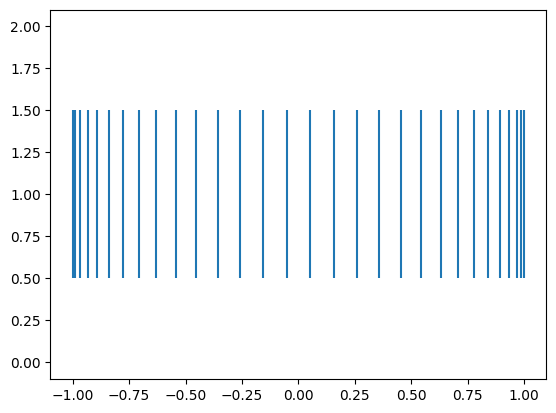

In [56]:
# Generate chebyshev nodes: https://en.wikipedia.org/wiki/Chebyshev_nodes

n = 30
# represents 2n equispaced (arc-len) points on a unit circle projected to diameter.
# these are also roots of the chebyshev polynomial of the first kind
# more dense near ends.
nodes = np.cos(np.pi * (0.5 + np.arange(0, n)) / n)

# note it's between [-1,1]
plt.eventplot(nodes)

2.0
1.999997833264124


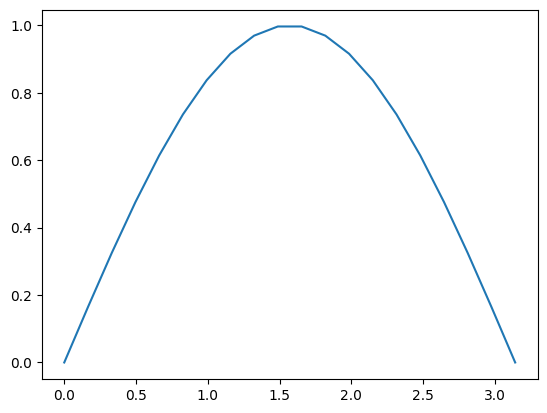

In [85]:
def integrate(func, a, b):
    # func can operate on vector of inputs
    n_grid = 30
    # [-1,1]
    chebyshev_nodes = jnp.cos(jnp.pi * (0.5 + jnp.arange(0, n_grid)) / n_grid)
    # [a,b]
    y = ((b - a) / 2) * chebyshev_nodes + ((b - a) / 2) + a
    # this is actually the jacobian!
    dy_coeff = (b - a) / 2  # times dx (x is chebyshev nodes)
    chebyshev_func_form_coeff = jnp.sqrt(1 - chebyshev_nodes**2)
    # chebyshev_func_form_coeff = 1
    weights = jnp.pi / n_grid

    return jnp.sum(weights * func(y) * dy_coeff * chebyshev_func_form_coeff)


# a, b = 0, 2 * jnp.pi
a, b = 0, jnp.pi
x = jnp.linspace(a, b, 20)
func = jnp.sin


def integral_gt(a, b):
    return -jnp.cos(b) - (-jnp.cos(a))


ans = integrate(func, a, b)

plt.plot(x, func(x))

print(integral_gt(a, b))
print(ans)

# back to eiv - ACTUALLY IGP

- the integration limits should be 0-chi_i as mentioned in the paper. However, for computational efficiency, we precompute it and just use the observation x for this.


In [2]:
def rbf_kernel(x, y, params):
    ell, sigma = params["lengthscale"], params["variance"]
    return sigma * jnp.exp(-0.5 * jnp.sum(jnp.square((x - y) / ell)))


# @jax.jit
def evaluate_kernel(x, y, kernel_fn, params):
    K = jax.vmap(lambda x1: jax.vmap(lambda y1: kernel_fn(x1, y1, params))(y))(x)
    return K


df = pd.read_csv("./NYC.csv")

In [4]:
x = df["Age"].to_numpy() / 1000
x_std = df["AgeError"].to_numpy() / 1000
y = df["RSL"].to_numpy()
y_std = df["RSLError"].to_numpy()
interval = 30 / 1000

x_grid = np.concatenate(
    [
        [(x - x_std).min()],
        np.arange(x.min(), x.max(), interval),
        [(x + x_std).max()],
    ]
)
x_star = x_grid - x.min()
x = x - x.min()

In [12]:
len(x_star)

50

In [5]:
def powered_exponential(x, y, params):
    p, kappa, sigma = params["p"], params["kappa"], params["variance"]
    return sigma * (p ** (jnp.abs(x - y) ** kappa))


@jax.jit
def integrate_kernel(x, x_star):
    # x is a vector of integral upper bounds
    kappa = 1.99
    integration_len = 30
    # [-1,1]
    chebyshev_nodes = jnp.cos(
        jnp.pi * (0.5 + jnp.arange(0, integration_len)) / integration_len
    )
    a = jnp.zeros_like(x)
    b = x

    # shape (len(x), 30)
    y = (
        ((b[:, None] - a[:, None]) / 2) * chebyshev_nodes[None, :]
        + ((b[:, None] - a[:, None]) / 2)
        + a[:, None]
    )
    # shape len(x), ngrid, 30
    quad1 = jnp.abs(y[:, None, :] - x_star[None, :, None]) ** kappa
    # print(y.shape)
    # print(quad1.shape)

    dy_coeff = (
        b[:, None, None] - a[:, None, None]
    ) / 2  # times dx (x is chebyshev nodes)
    chebyshev_func_form_coeff = jnp.sqrt(1 - chebyshev_nodes**2)
    weights = jnp.pi / integration_len

    quad2 = dy_coeff * weights * chebyshev_func_form_coeff[None, None, :]
    # print(quad2.shape)

    return quad1, quad2


print(x.shape)
print(x_star.shape)
quad1, quad2 = integrate_kernel(x, x_star)

(91,)
(50,)


In [ ]:
def invert(matrix):
    """
    Inverts a positive-definite matrix using Cholesky decomposition.
    """
    # Perform Cholesky decomposition
    L = jax.scipy.linalg.cho_factor(matrix, lower=True)

    # Use Cholesky factors to compute the inverse
    identity = jnp.eye(matrix.shape[0])
    matrix_inv = jax.scipy.linalg.cho_solve(L, identity)

    return matrix_inv


# # Example usage
# matrix = jnp.array([[4.0, 2.0], [2.0, 3.0]])
# matrix_inv = invert(matrix)
# print(matrix_inv)
# matrix_inv @ matrix # ~Identity

In [8]:
def igp(x, y, x_std, y_std):
    # N = x.shape[0]
    alpha = numpyro.sample("beta0", dist.Normal(0, 1000.0))
    p = numpyro.sample("p", dist.Uniform(0.0, 1.0))
    # p = numpyro.deterministic("p", 0.005)
    kernel_precision = numpyro.sample("tau_g", dist.Gamma(10.0, 100.0))
    kernel_variance = 1 / kernel_precision
    microscale_std = numpyro.sample("sigma", dist.Uniform(0.01, 1.0))
    params = {"p": p, "kappa": 1.99, "variance": 1}

    # kernel computation and EIV sampling
    # x_true = numpyro.sample("x_true", dist.Normal(x, x_std).to_event(1))

    C_w = evaluate_kernel(x_star, x_star, powered_exponential, params)
    C_w += jnp.eye(len(x_star)) * 1e-5  # jitter
    # sample rates
    # Sample w_m (rates on grid) from its prior MVN(0, K_ww)
    w_m = numpyro.sample(
        "w_m", dist.MultivariateNormal(jnp.zeros(len(x_star)), C_w * kernel_variance)
    )

    # Calculate C_w(-1)w_m
    # Cw_inv_w_m = jax.scipy.linalg.cho_solve(
    #     jax.scipy.linalg.cho_factor(C_w, lower=True),
    #     w_m,
    # )
    Cw_inv_w_m = jnp.matmul(invert(C_w), w_m)

    # integral approximation
    # C_w is multiplied by variance, but in its inverse has the reciprocal of variance
    # set var as 1 and avoid variance mult
    K_hw = jnp.sum(p**quad1 * quad2, axis=2)  # * kernel_variance
    h_x = jnp.matmul(K_hw, Cw_inv_w_m)

    # h_integral_cond_exp = jnp.matmul(K_hw, K_ww_inv_w_m)
    with numpyro.plate("y_plate", len(y)):
        # numpyro.sample(
        #     "x_likelihood",
        #     dist.Normal(loc=x_true, scale=x_std),
        #     obs=x,
        # )  # not used, but used in eivigp_estquad.txt.
        numpyro.sample(
            "y",
            dist.Normal(alpha + h_x, jnp.sqrt(y_std**2 + microscale_std**2)),
            obs=y,
        )


mcmc = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        igp,
        dense_mass=True,
        # init_strategy=numpyro.infer.init_to_median(),
        # init_strategy=numpyro.infer.init_to_sample(),
    ),
    # numpyro.infer.SA(eiv_igp),
    num_warmup=500,
    num_samples=1000,
    num_chains=1,
)
mcmc.run(jax.random.PRNGKey(1), x=x, y=y, x_std=x_std, y_std=y_std)
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [05:40<00:00,  4.41it/s, 15 steps of size 3.12e-01. acc. prob=0.86]   



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -1.70      0.05     -1.70     -1.80     -1.61   1113.67      1.00
         p      0.02      0.04      0.01      0.00      0.06    211.26      1.00
     sigma      0.02      0.01      0.01      0.01      0.02    746.75      1.00
     tau_g      0.10      0.03      0.09      0.05      0.15    460.65      1.00
    w_m[0]      0.08      1.00      0.08     -1.54      1.80   1121.20      1.00
    w_m[1]      0.19      0.76      0.21     -1.01      1.55   1029.03      1.00
    w_m[2]      0.28      0.61      0.29     -0.70      1.30    972.74      1.00
    w_m[3]      0.36      0.47      0.36     -0.32      1.20    965.99      1.00
    w_m[4]      0.44      0.35      0.45     -0.14      1.02    993.04      1.00
    w_m[5]      0.51      0.28      0.52      0.11      1.01   1050.48      1.00
    w_m[6]      0.57      0.24      0.58      0.15      0.94   1327.61      1.00
    w_m[7]      0.62      0

In [9]:
# note that both are x_star here unlike before
quad1_pred, quad2_pred = integrate_kernel(x_star, x_star)
# can make all this cleaner by passing quads as params to mcmc func and getting posterior predictive
# with updated arguments


@jax.jit
def calculate_one_sample_pred_vmap(sample_params, sample_w_m):
    p_i = sample_params["p"]
    # var_i = sample_params["variance"]
    beta0_i = sample_params["beta0"]
    kappa = 1.99  # Or get from params if varied

    # Evaluate C_ww on original grid x_star
    kernel_params_i = {"p": p_i, "kappa": kappa, "variance": 1}
    C_ww_i = evaluate_kernel(x_star, x_star, powered_exponential, kernel_params_i)
    C_ww_i += jnp.eye(len(x_star)) * 1e-6  # Add jitter

    # Solve C_ww_inv @ w_m efficiently
    # L_ww_i, low_i = jax.scipy.linalg.cho_factor(C_ww_i, lower=True)
    # Cw_inv_w_m_i = jax.scipy.linalg.cho_solve((L_ww_i, low_i), sample_w_m)

    Cw_inv_w_m_i = jnp.matmul(invert(C_ww_i), sample_w_m)
    # Calculate K_hw using precomputed structure and current sample params
    # K_hw_orig_i = var_i * jnp.sum(
    #     p_i**quad1_pred * quad2_pred, axis=2
    # )  # Sum over L axis
    K_hw_orig_i = jnp.sum(p_i**quad1_pred * quad2_pred, axis=2)

    # Calculate h prediction on original grid
    h_pred_i = beta0_i + jnp.matmul(K_hw_orig_i, Cw_inv_w_m_i)

    # Rate prediction is just w_m
    w_pred_i = sample_w_m

    return h_pred_i, w_pred_i


samples = mcmc.get_samples()
if "kernel_variance" not in samples:
    samples["kernel_variance"] = 1.0 / samples["tau_g"]


sl_pred, rate_pred = jax.vmap(calculate_one_sample_pred_vmap)(
    {
        "p": samples["p"],
        "variance": samples["kernel_variance"],
        "beta0": samples["beta0"],
    },
    samples["w_m"],
)

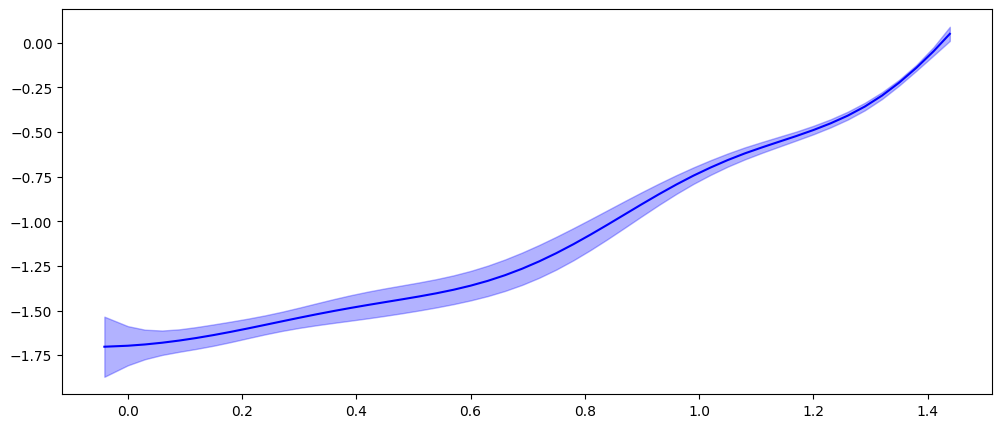

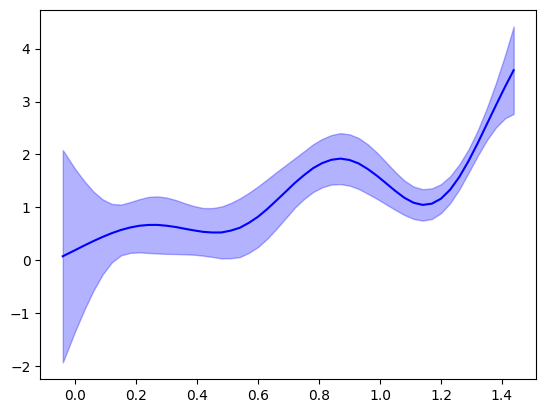

In [10]:
h_mean = np.mean(sl_pred, axis=0)
h_std = np.std(sl_pred, axis=0)
h_lower_ci = h_mean - 2 * h_std
h_upper_ci = h_mean + 2 * h_std

w_mean = np.mean(samples["w_m"], axis=0)
w_std = np.std(samples["w_m"], axis=0)
w_lower_ci = w_mean - 2 * w_std
w_upper_ci = w_mean + 2 * w_std


plt.figure(figsize=(12, 5))
plt.plot(x_star, h_mean, color="blue")
plt.fill_between(
    x_star,
    h_lower_ci,
    h_upper_ci,
    color="blue",
    alpha=0.3,
)
plt.show()

plt.plot(x_star, w_mean, color="blue")
plt.fill_between(
    x_star,
    w_lower_ci,
    w_upper_ci,
    color="blue",
    alpha=0.3,
)
plt.show()

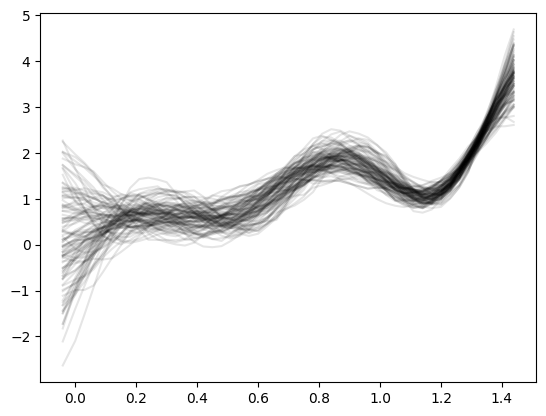

In [11]:
for i in range(samples["w_m"].shape[0]):
    plt.plot(x_star, samples["w_m"][i], c="black", alpha=0.1)
    if i == 100:
        break